This notebook has been used to produce plots for my article on the Roll Model under serial dependence [(find it here)](https://python.plainenglish.io/roll-model-under-serial-dependence-f9ba693446f9)

*I sadly forgot to set a seed when generating the plots for the article, so my plots here are slightly different*

In [9]:
# imports
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

Part 1: Roll Model

In [10]:
def AR1_process_roll_model(phi, sigma_v, T):
    """
    Generate a path of an autoregressive process of order 1 (AR(1)).
    This is under the Roll Model assumptions, so the values of the
    process can either be -1 or 1.
    
    Parameters:
    - phi (float): The autoregressive parameter.
    - sigma_v (float): The standard deviation of the white noise.
    - T (int): The number of time steps.
    
    Returns:
    - numpy.ndarray: An array containing the generated path.
    """
    # Initialize an array to store the path
    path = np.zeros(T)

    # Generate the first value of the path
    path[0] = np.sign(np.random.uniform(-1, 1))
    
    # Generate the remaining values of the path
    for t in range(1, T):
        # Generate the white noise term
        v_t = np.random.normal(loc=0, scale=sigma_v)
        
        # Calculate the value of the AR(1) process
        value = phi * path[t-1] + v_t
        
        # Take the sign of the value to get +1 or -1
        path[t] = np.sign(value)

    return path


def mt_process(m_0, sigma_v, T):
    """
    Generate a path of a mean-reverting process.
    
    Parameters:
    - m_0 (float): The initial value of the process.
    - sigma_v (float): The standard deviation of the white noise.
    - T (int): The number of time steps.
    
    Returns:
    - numpy.ndarray: An array containing the generated path.
    """
    # Initialize an array to store the path
    path = np.zeros(T)
    path[0] = m_0
    
    # Generate the values of the process
    for t in range(1, T):
        # Generate the white noise term
        v_t = np.random.normal(loc=0, scale=sigma_v)
        
        # Calculate the current value of the process
        value = path[t-1] + v_t
        path[t] = value

    return path

Simulate the q_t process

100%|██████████| 500/500 [00:14<00:00, 34.58it/s]


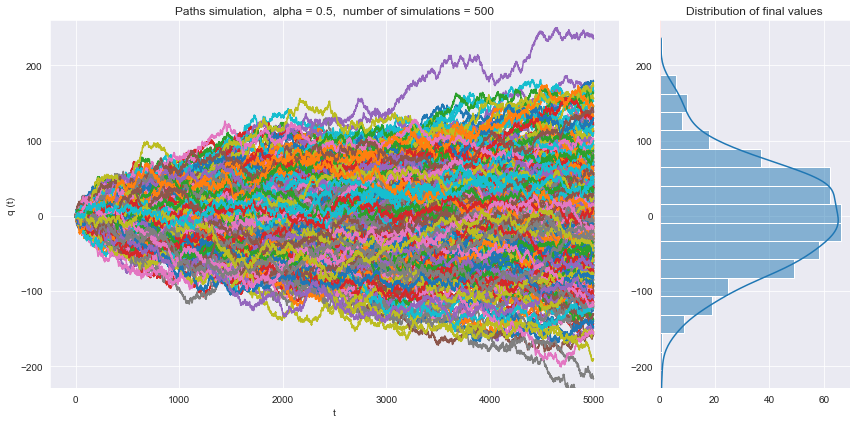

Theoretical variance = 1.0
Computed variance = 0.49402792054124245


In [11]:
# Process parameters
alpha = 0.5
phi = 2*alpha - 1  # AR(1) coefficient
sigma_v = 1.0  # noise std dev
T = 5000  # time length
n_sim = 500 # number of simulations

q_tot = pd.DataFrame()
for sim in tqdm(range(n_sim)):
    path = AR1_process_roll_model(phi, sigma_v, T)
    df = pd.DataFrame({sim: path})
    q_tot = pd.concat([q_tot, df[[sim]]], axis=1)


# plot the paths
sns.set_style("darkgrid")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})

min_y = np.min(q_tot.cumsum().tail(1).T[T-1]) * (0.9)
max_y = np.max(q_tot.cumsum().tail(1).T[T-1]) * (1.1)

ax1.plot(q_tot.cumsum())
ax1.set_title(f'Paths simulation,  alpha = {alpha},  number of simulations = {n_sim}')
ax1.set_ylim(min_y, max_y)
ax1.set_xlabel('t')
ax1.set_ylabel('q (t) ')

sns.histplot(y=q_tot.cumsum().tail(1).T[T-1], kde=True, ax=ax2)
sns.kdeplot(y=q_tot.cumsum().tail(1).T[T-1], color='r', ax=ax2)
ax2.set_title('Distribution of final values')
ax2.set_ylim(min_y, max_y)
ax2.set_xlabel('')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

print(f"Theoretical variance = {sigma_v**2 / (1 - (phi**2))}")
print(f"Computed variance = {(q_tot.cumsum().var(axis=1) / T).mean()}")

Simulations for m_t process

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:10<00:00, 46.88it/s]


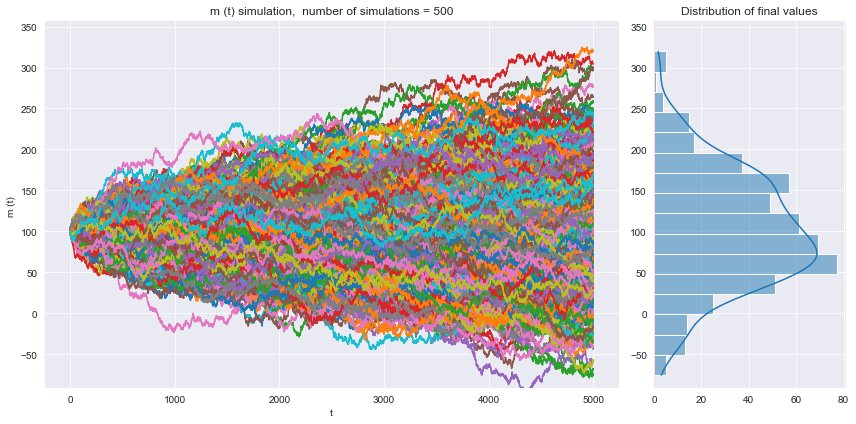

In [12]:
# Parameters
sigma_v = 1.0
m_0 = 100

m_tot = pd.DataFrame()
for sim in tqdm(range(n_sim)):
    # Simula il path del processo AR(1)
    path = mt_process(m_0, sigma_v, T)
    df = pd.DataFrame({sim: path})
    m_tot = pd.concat([m_tot, df[[sim]]], axis=1)


# plot
sns.set_style("darkgrid")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})

min_y = m_tot.min(axis=1).min() * (0.9)
max_y = m_tot.max(axis=1).max() * (1.1)

ax1.plot(m_tot)
ax1.set_title(f'm (t) simulation,  number of simulations = {n_sim}')
ax1.set_ylim(min_y, max_y)
ax1.set_xlabel('t')
ax1.set_ylabel('m (t) ')

sns.histplot(y=m_tot.tail(1).T[T-1], kde=True, ax=ax2)
sns.kdeplot(y=m_tot.tail(1).T[T-1], color='r', ax=ax2)
ax2.set_title('Distribution of final values')
ax2.set_ylim(min_y, max_y)
ax2.set_xlabel('')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

Simulations for the p_t process

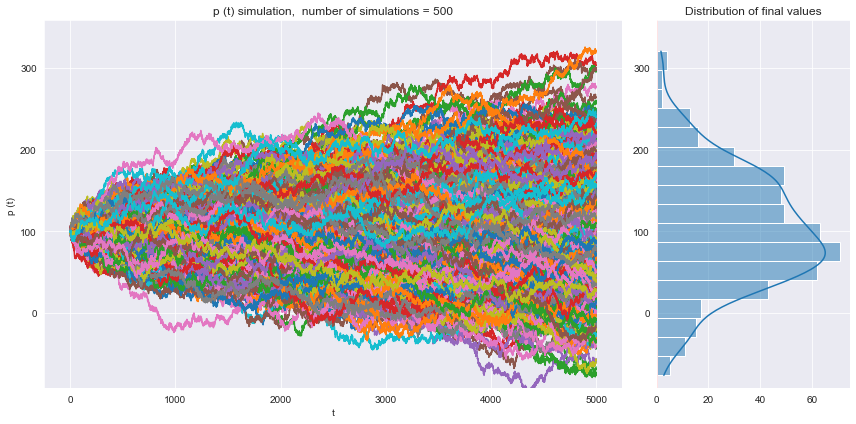

In [13]:
c = 1 # cost per trade
p = m_tot + q_tot * c # transaction price
a = m_tot + c # ask price
b = m_tot - c # bid price

# plot
sns.set_style("darkgrid")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})

min_y = p.min(axis=1).min() * (0.9)
max_y = p.max(axis=1).max() * (1.1)

ax1.plot(p)
ax1.set_title(f'p (t) simulation,  number of simulations = {n_sim}')
ax1.set_ylim(min_y, max_y)
ax1.set_xlabel('t')
ax1.set_ylabel('p (t) ')

sns.histplot(y=p.tail(1).T[T-1], kde=True, ax=ax2)
sns.kdeplot(y=p.tail(1).T[T-1], color='r', ax=ax2)
ax2.set_title('Distribution of final values')
ax2.set_ylim(min_y, max_y)
ax2.set_xlabel('')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

Plot a realisation of Roll Model under serial correlation

Text(0, 0.5, 'p (t)')

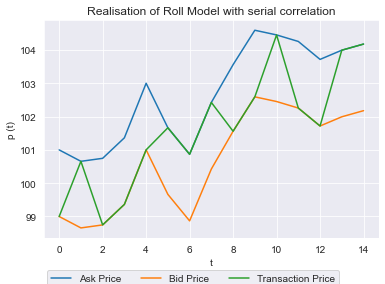

In [14]:
fig = plt.figure()
a[1].head(15).plot()
b[1].head(15).plot()
p[1].head(15).plot()
fig.legend(['Ask Price','Bid Price','Transaction Price'], loc='lower center', ncol=3, borderaxespad=-0.3)
plt.title('Realisation of Roll Model with serial correlation')
plt.xlabel('t')
plt.ylabel('p (t)')

Simulate now a generic AR(1) process and show some of its properties

In [15]:
def simulate_ar1_process(phi, v, n):
    """
    Simulate an autoregressive process of order 1 (AR(1)).
    This is not under the Roll Model, so the value of the process can be a real number.

    Parameters:
    - phi (float): The autoregressive parameter.
    - v (numpy.ndarray): Array containing the white noise values.
    - n (int): The number of time steps.

    Returns:
    - numpy.ndarray: Array containing the simulated AR(1) process.
    """
    q = np.zeros(n)
    q[0] = v[0]  # Set the initial value of the process
    for i in range(1, n):
        q[i] = phi * q[i-1] + v[i]  # Simulate the AR(1) process
    return q

def simulate_ar1_process_with_perturbation(phi, v, perturbation, n):
    """
    Simulate an autoregressive process of order 1 (AR(1)) with perturbation.
    This is not under the Roll Model, so the value of the process can be a real number.

    Parameters:
    - phi (float): The autoregressive parameter.
    - v (numpy.ndarray): Array containing the white noise values.
    - perturbation (float): The perturbation value added to the initial value.
    - n (int): The number of time steps.

    Returns:
    - numpy.ndarray: Array containing the simulated AR(1) process with perturbation.
    """
    q_perturbed = np.zeros(n)
    q_perturbed[0] = v[0] + perturbation  # Set the initial value of the process with perturbation
    for i in range(1, n):
        q_perturbed[i] = phi * q_perturbed[i-1] + v[i]  # Simulate the AR(1) process with perturbation
    return q_perturbed

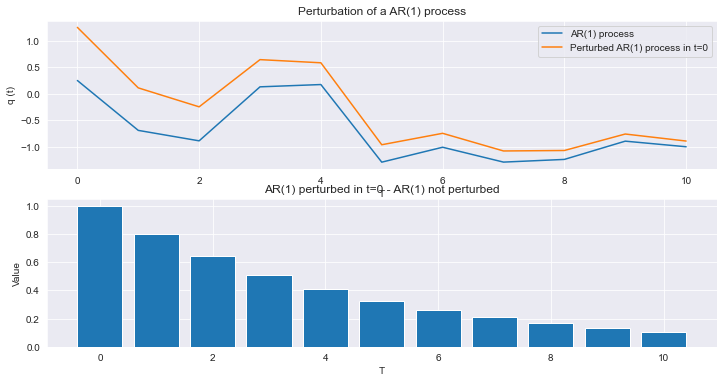

In [16]:
# Parameters
phi = 0.8
n = 11  # simulation length

# error term
v = np.random.normal(0, 1, n)

# AR(1) process
ar1_process = simulate_ar1_process(phi, v, n)

# AR(1) with perturbation in v_0
perturbation = 1
ar1_process_with_perturbation = simulate_ar1_process_with_perturbation(phi, v, perturbation, n)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))

# plot
ax1.plot(ar1_process, label='AR(1) process')
ax1.plot(ar1_process_with_perturbation, label='Perturbed AR(1) process in t=0')
ax1.set_xlabel('T')
ax1.set_ylabel('q (t)')
ax1.set_title('Perturbation of a AR(1) process')
ax1.legend()


ax2.bar(range(0,n), ar1_process_with_perturbation - ar1_process, 
        label='AR(1) perturbed in t=0 - AR(1) not perturbed')
ax2.set_xlabel('T')
ax2.set_ylabel('Value')
ax2.set_title('AR(1) perturbed in t=0 - AR(1) not perturbed')

plt.show()
